# Mutations per Mbp

After finding the length of each gene panel in bp, we can find the mutation per Mbp for each individual. This might be interesting if we can plot the mutation/Mbp for each age group.

## Setup

In [1]:
library("ggplot2")
library('dplyr')
library('RColorBrewer')

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Get data

In [2]:
mutation_data <- read.table("../../data/genie_v15/data_mutations_extended.txt", sep="\t", quote="", head=TRUE)

dim(mutation_data)
#colnames(mutation_data)
#head(mutation_data)

[1] 1840311      64

In [3]:
panel_length <- read.csv("../../derived_data/genie_v15/panel_length_table.csv", header=TRUE, stringsAsFactors=FALSE)

panel_length <- panel_length[,-1]

#dim(panel_length)
#head(panel_length)

In [4]:
sample_data <- read.table("../../data/genie_v15/data_clinical_sample.txt", sep="\t", quote="", head=TRUE)

#dim(sample_data)
#head(sample_data)

In [5]:
patient_data <- read.table("../../data/genie_v15/data_clinical_patient.txt", sep="\t", quote="", head=TRUE)

#dim(patient_data)
#head(patient_data)

## The table

I would like to create a table with one row for each patient, containing some clinical data. In this table I want to add how many mutations each patients sample has, how long the assay is in bp and the mutation rate based on the other two columns.

We create the first step for this table below.

In [6]:
my_table <- sample_data %>% select(PATIENT_ID, SAMPLE_ID, AGE_AT_SEQ_REPORT, SEQ_ASSAY_ID, SAMPLE_TYPE, CANCER_TYPE)

# I want to add a column containing the sex of the patient
# So I cut patient data down to patient ID and sex
patient_data <- patient_data[,1:2]

# Then I left-merge by patient ID
my_table <- left_join(my_table, patient_data, join_by(PATIENT_ID))

# Checking the new table
#dim(my_table)
#head(my_table)

In [7]:
# Add length of the panel with a left join
my_table <- left_join(my_table, panel_length, join_by(SEQ_ASSAY_ID == Assay_ID))

# Checking the results
dim(my_table)
head(my_table)

[1] 198041      8

,PATIENT_ID,SAMPLE_ID,AGE_AT_SEQ_REPORT,SEQ_ASSAY_ID,SAMPLE_TYPE,CANCER_TYPE,SEX,length_in_bp
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,GENIE-VICC-101416,GENIE-VICC-101416-unk-1,52,VICC-01-T7,Primary,Appendiceal Cancer,Female,21921998
2,GENIE-VICC-102225,GENIE-VICC-102225-unk-1,31,VICC-01-T7,Metastasis,Colorectal Cancer,Female,21921998
3,GENIE-VICC-102424,GENIE-VICC-102424-unk-1,63,VICC-01-T7,Metastasis,Cancer of Unknown Primary,Female,21921998
4,GENIE-VICC-102966,GENIE-VICC-102966-unk-1,64,VICC-01-T7,Metastasis,Non-Small Cell Lung Cancer,Male,21921998
5,GENIE-VICC-103244,GENIE-VICC-103244-unk-1,50,VICC-01-T5A,Primary,Breast Cancer,Female,15610420
6,GENIE-VICC-103477,GENIE-VICC-103477-unk-1,40,VICC-01-D2,Primary,Soft Tissue Sarcoma,Male,23926966


## Handling pseudo-replicates

In our data there are individuals with more than one sample, and we need to handle these pseudo-replicates for the data to be usefull.

We have created the following filtering:
1) If there are samples with Primary sample types, we prioritise these
2) If there are no samples with a Primary sample type, or multiple, we keep the ones with the longest Assay
3) If there are still multiple samples for an individual, we discard that individuals rows

The remaining rows should contain one sample for each individual, and that is the sample we base our estimates on.

In [8]:
## This entire code-chunck takes a while to run, so it has been commented out
## The result from the chunck is saved in a file which is loaded at the sart of the next chunck
#
## We create a table with Patient_ID and how often each shows up in my_table$Patient_ID
## Var1 contains the ID and Freq contains the count
#n_occur <- data.frame(table(my_table$PATIENT_ID))
#
## Var1 is by default a factor, but we want it as a character
#n_occur$Var1 <- as.character(n_occur$Var1)
#
## We create a list containing all patient IDs with only one sample
#singles <- n_occur[n_occur$Freq == 1, 1]
#
## All Patients with more than one sample are kept in the table
#n_occur <- n_occur[n_occur$Freq > 1,]
#
## We create a list of the ones we want to keep
#keep_list <- list()
#
## And a list of the ones we don't (specifically the ones we have to throw away)
#unmatched <- list()
#
## For the patients with only one sample...
#for (p_id in singles){
#    # We find the index they have in my_table...
#    matches <- which(my_table$PATIENT_ID == p_id)
#    for (m in matches){
#        # And add that index to our list of keepers
#        keep_list[length(keep_list)+1] <- m
#    }
#}
#
## For the patients with multiple samples...
#for (p_id in n_occur$Var1){
#    
#    # We find all the indexes they have in my_table...
#    matches <- which(my_table$PATIENT_ID == p_id)
#    
#    # Create an empty list of 
#    primarys <- list()
#    
#    # And for each match
#    for (m in matches){
#        # We check if the sample type is a primary Tumor
#        if (my_table$SAMPLE_TYPE[m] == 'Primary'){
#            # The ones that do have a primary tumor are saved in the previously empty list
#            primarys[length(primarys)+1] <- m
#        }
#    }
#    
#    # If there is only one of the samples for the one patient that is from a primary sample type
#    if  (length(primarys) == 1){
#        # We keep that one and disregard the others
#        keep_list[length(keep_list)+1] <- primarys[1]
#    
#    # If there is more than one sample with a primary tumor we need to filter by assay
#    } else if (length(primarys) > 1){
#        # We create an empty list
#        max_bp_list <- list()
#        
#        # Find the maximum assay length for the patient
#        max_length <- max(my_table[which(my_table$PATIENT_ID == p_id), 7])
#        
#        # And go through each match
#        for (m in matches){
#            # And if the length in bp is the maximum, and the sample is Primary
#            if (my_table$length_in_bp[m] == max_length & my_table$SAMPLE_TYPE[m] == 'Primary'){
#                # We save the index to the list
#                max_bp_list[length(max_bp_list)+1] <- m
#            }
#        }
#        
#        # If, after running through the matches, there is only one row where
#        # the sample is primary and the assay is the longest
#        if (length(max_bp_list) == 1){
#            # We keep that match for the individual
#            keep_list[length(keep_list)+1] <- max_bp_list[1]
#        }
#        
#        # If not, and there are still multiple matches, we cannot filter by this
#        else{
#            # We have to add all the matches to the unmatched list, and remove them
#            for (m in matches){
#                unmatched[length(unmatched)+1] <- m
#            }
#        }
#        
#    # If there are no primaty samples
#    } else if (length(primarys) == 0){
#        # We have to just filter by assay length (like before)
#        max_bp_list <- list()
#        
#        max_length <- max(my_table[which(my_table$PATIENT_ID == p_id), 7])
#        
#        for (m in matches){
#            if (my_table$length_in_bp[m] == max_length){
#                max_bp_list[length(max_bp_list)+1] <- m
#            }
#        }
#            
#        if (length(max_bp_list) == 1){
#            keep_list[length(keep_list)+1] <- max_bp_list[1]
#            
#        } else{
#            for (m in matches){
#                unmatched[length(unmatched)+1] <- m
#            }
#        }
#        }
#}
#
## Only keeping the non-duplicated rows
#my_table <- my_table[unlist(keep_list), ]
#
## Saving the results
#write.csv(my_table, '../../derived_data/genie_v15/mutation_no_duplicates.csv', row.names=TRUE)

## Mutation per bp/Mbp calculations

In [9]:
# We read in the my_table csv file
# (This makes testing the code easier, as I don't have to run all the previous code again if/when I make a mistake)
my_table <- read.csv("../../derived_data/genie_v15/mutation_no_duplicates.csv", header=TRUE, stringsAsFactors=FALSE)

# Removing the index row from my_table
my_table <- my_table[,-1]

# Making a dataframe with number of occurences of each sample_id in the mutation data
mutation_counter <- data.frame(table(mutation_data$Tumor_Sample_Barcode))

# Renaming the columns
mutation_counter <- rename(mutation_counter, count = Freq)
mutation_counter <- rename(mutation_counter, SAMPLE_ID = Var1)

# And making the sample_id a character vector, instead of a factor
mutation_counter$SAMPLE_ID <- as.character(mutation_counter$SAMPLE_ID)

# joining the mutation count for each sample, by matching sample id in the two tables
my_table <- full_join(mutation_counter, my_table, join_by(SAMPLE_ID))

#head(my_table)

# Calculating the mutation pr. Mbp
my_table$mutation_per_Mbp <- (my_table$count/(my_table$length_in_bp/1000000))

# Since we merge with the entire mutation data, we want to remove rows where there is no patient ID
# The ones with no Patient ID were not in our duplicate-filtered dataframe
my_table <- my_table[!is.na(my_table$PATIENT_ID),]

# Removing NA counts
my_table <- my_table %>% filter(!is.na(count))

# Removing rows where the panel length is zero
my_table <- my_table %>% filter(length_in_bp != 0)

# Checking the results
head(my_table)

,SAMPLE_ID,count,PATIENT_ID,AGE_AT_SEQ_REPORT,SEQ_ASSAY_ID,SAMPLE_TYPE,CANCER_TYPE,SEX,length_in_bp,mutation_per_Mbp
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,GENIE-CHOP-C1002819-BS79B4V9EZ,4,GENIE-CHOP-C1002819,<18,CHOP-STNGS,Primary,UNKNOWN,Female,9717318,0.4116362
2,GENIE-CHOP-C1003188-BSHKNH1HNP,10,GENIE-CHOP-C1003188,<18,CHOP-STNGS,Primary,Embryonal Tumor,Female,9717318,1.0290905
3,GENIE-CHOP-C1003434-BSA2BH219E,4,GENIE-CHOP-C1003434,<18,CHOP-STNGS,Metastasis,Glioma,Male,9717318,0.4116362
4,GENIE-CHOP-C1004049-BSYY1EQ16F,7,GENIE-CHOP-C1004049,<18,CHOP-STNGS,Primary,Glioma,Male,9717318,0.7203634
5,GENIE-CHOP-C1012044-BSTA04C03Y,13,GENIE-CHOP-C1012044,<18,CHOP-STNGS,Primary,Glioma,Male,9717318,1.3378177
6,GENIE-CHOP-C1026312-BSVS8NWRB4,5,GENIE-CHOP-C1026312,<18,CHOP-STNGS,Primary,Glioma,Female,9717318,0.5145453


In [10]:
# Removing hyper-mutations
my_table <- my_table %>% filter(mutation_per_Mbp < 10)

In [11]:
# How many total?
dim(my_table)

[1] 137571     10

## Visualising sample results

I want to visualise the mut/Mbp partial results that are per. sample.

In [12]:
# Make plots wider 
options(repr.plot.width=7, repr.plot.height=4)

In [13]:
# Finding quantiles for the plots
#quantile(my_table$mutation_per_Mbp, probs = seq(0, 1, 0.25))
#log(quantile(my_table$mutation_per_Mbp, probs = seq(0, 1, 0.25)))

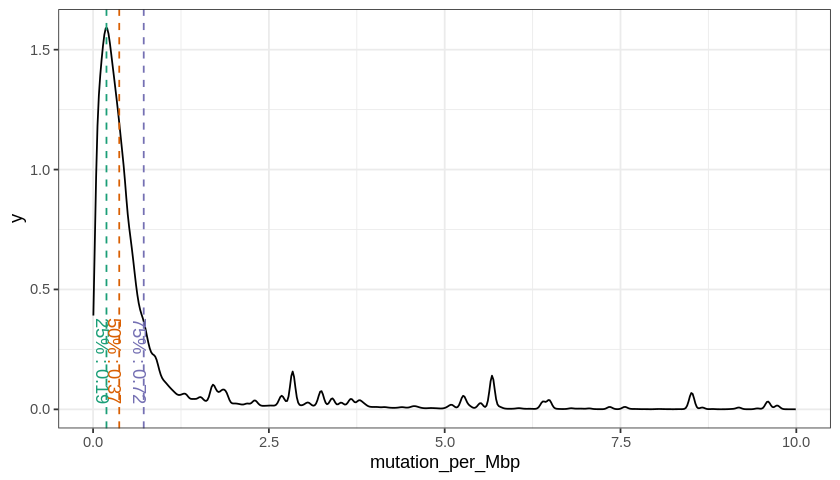

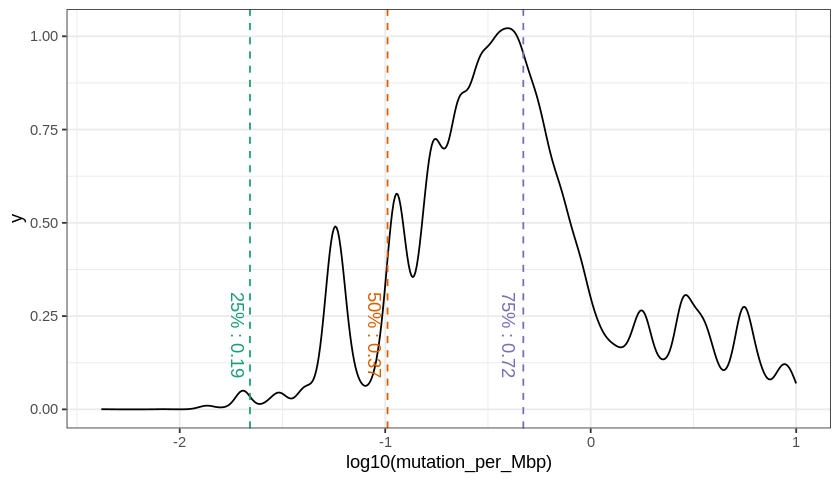

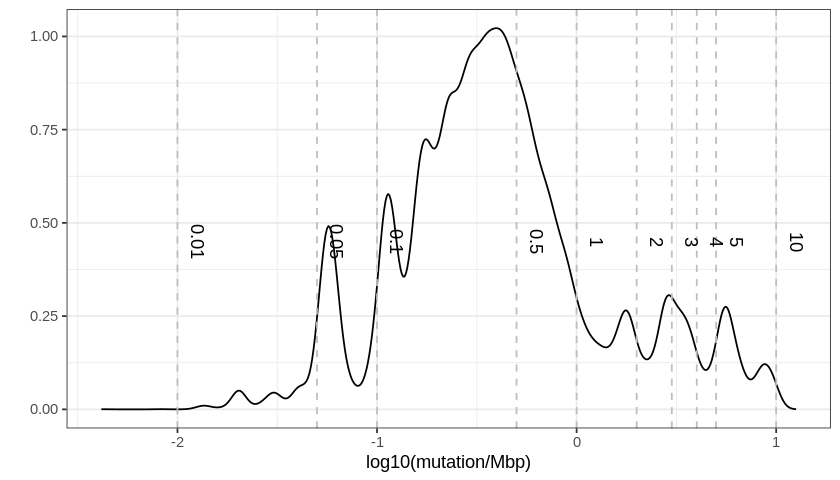

In [14]:
# Making density distributions

# Not log10-transformed with marked quantiles
ggplot(my_table, aes(mutation_per_Mbp)) +
geom_density() +
theme_bw() +
geom_vline(xintercept=c(0.190477460325926,0.372043681117109,0.72036337598502), linetype='dashed', color=c('#1b9e77','#d95f02','#7570b3')) +
annotate("text", x = c(0.13,0.31,0.66), y = .2, label = c("25% : 0.19", "50% : 0.37", '75% : 0.72'), angle = -90, color=c('#1b9e77','#d95f02','#7570b3'))

# log10-transfomed with quantiles
ggplot(my_table, aes(log10(mutation_per_Mbp))) +
geom_density() +
theme_bw() +
geom_vline(xintercept=c(-1.65822140991464,-0.988744009244636,-0.327999505416546), linetype='dashed', color=c('#1b9e77','#d95f02','#7570b3')) +
annotate("text", x = c(-1.72,-1.05,-0.4), y = .2, label = c("25% : 0.19", "50% : 0.37", '75% : 0.72'), angle = -90, color=c('#1b9e77','#d95f02','#7570b3'))

# log10-transformed with annotated marks
ggplot(my_table, aes(log10(mutation_per_Mbp))) +
geom_density() +
theme_bw() +
geom_vline(xintercept=log10(c(0.01,0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10)), linetype='dashed', colour = 'grey') +
annotate("text", x = log10(c(0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4, 5, 10))+.1, y = .45, label = c('0.01', '0.05', '0.1', '0.5', '1', '2', '3', '4', '5', '10'), angle = -90) +
xlab('log10(mutation/Mbp)') +
ylab('')

### Scatterplot

In [15]:
# We make age in integer
my_table['AGE_AT_SEQ_REPORT'][my_table['AGE_AT_SEQ_REPORT'] == '<18'] <- '17'
my_table['AGE_AT_SEQ_REPORT'][my_table['AGE_AT_SEQ_REPORT'] == '>89'] <- '90'
my_table['AGE_AT_SEQ_REPORT'][my_table['AGE_AT_SEQ_REPORT'] == 'Unknown'] <- NA

my_table$AGE_AT_SEQ_REPORT <- as.numeric(my_table$AGE_AT_SEQ_REPORT)

my_table <- na.omit(my_table)

dim(my_table)

[1] 136902     10

In [16]:
# We make Unknown and Other sex into NA
my_table['SEX'][my_table['SEX'] == 'Unknown'] <- NA
my_table['SEX'][my_table['SEX'] == 'Other'] <- NA

my_table <- na.omit(my_table)

dim(my_table)

[1] 136885     10

In [17]:
# We subset the data to only containing Metastasis and Primary tumor samples
my_table <- subset(my_table, SAMPLE_TYPE=='Metastasis' | SAMPLE_TYPE=='Primary')

dim(my_table)

[1] 117838     10

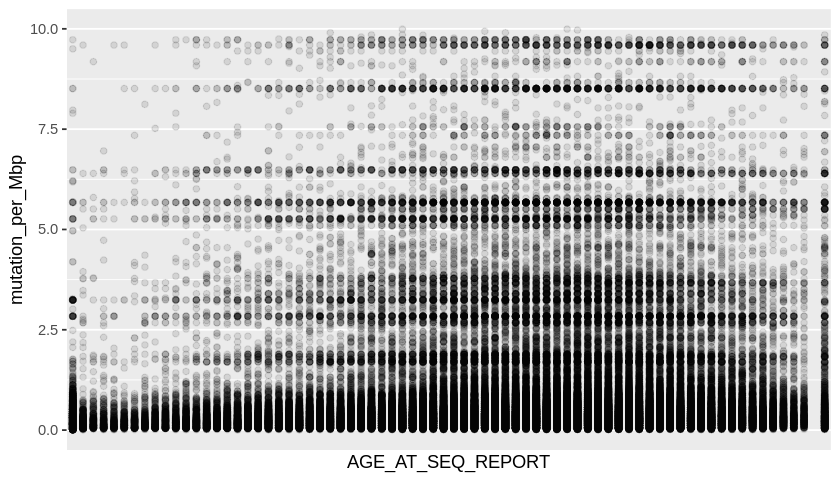

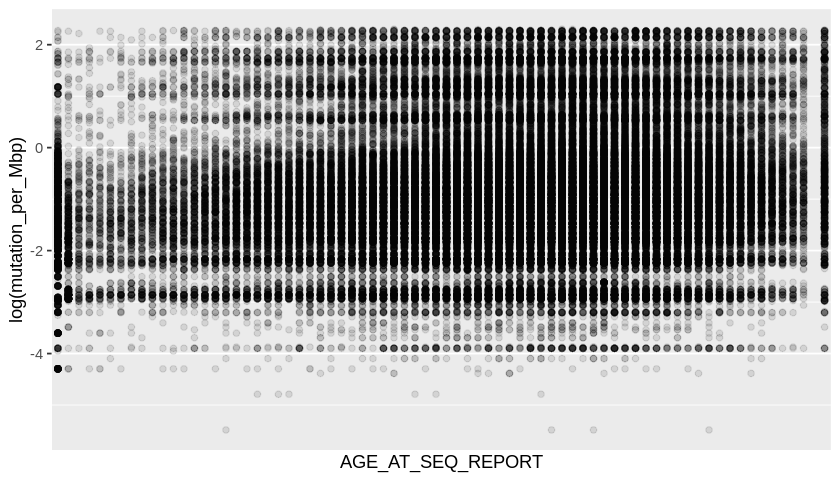

In [18]:
# Dot plot
ggplot(my_table, aes(x=AGE_AT_SEQ_REPORT, y=mutation_per_Mbp)) +
  geom_point(alpha=0.1) +
  scale_x_discrete(guide = guide_axis(angle = -90))

ggplot(my_table, aes(x=AGE_AT_SEQ_REPORT, y=log(mutation_per_Mbp))) +
  geom_point(alpha=0.1) +
  scale_x_discrete(guide = guide_axis(angle = -90))

### Age-interval density plot

In [19]:
# Creating the age-interval column
my_table$age_interval <- '<45'
my_table$age_interval[my_table$AGE_AT_SEQ_REPORT>=45] <- '[45-55['
my_table$age_interval[my_table$AGE_AT_SEQ_REPORT>=55] <- '[55-65['
my_table$age_interval[my_table$AGE_AT_SEQ_REPORT>=65] <- '[65-75['
my_table$age_interval[my_table$AGE_AT_SEQ_REPORT>=75] <- '>=75'

# Defining the order
age_interval_levels <- c('<45',
                         '[45-55[',
                         '[55-65[',
                         '[65-75[',
                         '>=75')

# Making it a factor
my_table$age_interval <- factor(my_table$age_interval, levels=age_interval_levels)

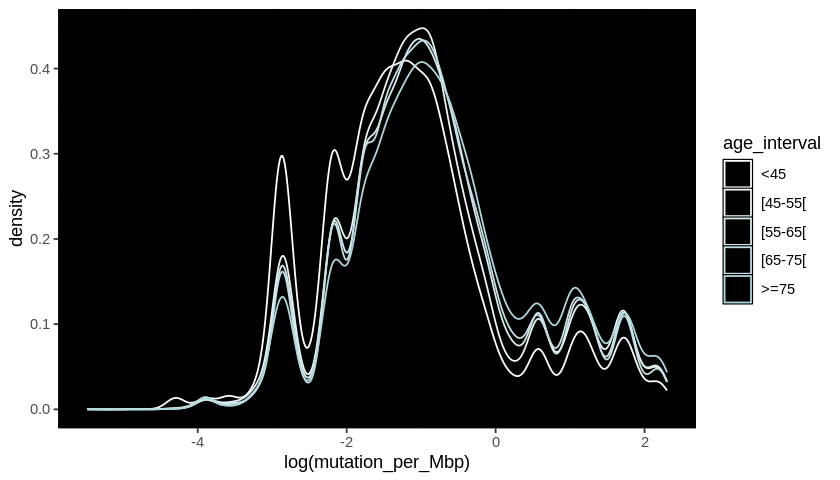

In [20]:
# Density
#ggplot(my_table, aes(x=log(mutation_per_Mbp))) +
#  geom_density() +
#  facet_wrap(~age_interval)

ggplot(my_table, aes(x=log(mutation_per_Mbp), colour=age_interval)) +
  geom_density() +
  scale_color_manual(values=c('#ffffff', '#eaf5f6', '#d6ebed', '#c2e1e4', '#aed8db', '#9bced3', '#87c5ca', '#73bbc1', '#60b2b9', '#4ca8b0', '#3c9ea6', '#2d959d', '#1e8c94', '#0f828b', '#007982', '#00727a')) +
  theme(panel.background = element_rect(fill = 'black', color = 'black'), panel.grid = element_line(colour = "black"))

## Linear regression

I want to examine if there is a linear relationship between age, sex and mutatitions per Mbp. 

In [21]:
reg_table <- my_table

In [22]:
#define model with all predictors
full_model <- lm(log(mutation_per_Mbp) ~ AGE_AT_SEQ_REPORT + SEX + SAMPLE_TYPE+length_in_bp, data=reg_table)

summary(full_model)

#define model with all predictors
not_log <- lm(mutation_per_Mbp ~ AGE_AT_SEQ_REPORT + SEX + SAMPLE_TYPE+length_in_bp, data=reg_table)

summary(not_log)


Call:
lm(formula = log(mutation_per_Mbp) ~ AGE_AT_SEQ_REPORT + SEX + 
    SAMPLE_TYPE + length_in_bp, data = reg_table)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7090 -0.7455 -0.0943  0.6080  5.1724 

Coefficients:
                     Estimate Std. Error  t value Pr(>|t|)    
(Intercept)        -9.055e-01  1.481e-02  -61.135   <2e-16 ***
AGE_AT_SEQ_REPORT   8.674e-03  2.127e-04   40.782   <2e-16 ***
SEXMale             1.449e-02  6.652e-03    2.178   0.0294 *  
SAMPLE_TYPEPrimary -1.186e-01  7.028e-03  -16.875   <2e-16 ***
length_in_bp       -2.100e-08  1.569e-10 -133.857   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.135 on 117833 degrees of freedom
Multiple R-squared:  0.1494,	Adjusted R-squared:  0.1494 
F-statistic:  5175 on 4 and 117833 DF,  p-value: < 2.2e-16



Call:
lm(formula = mutation_per_Mbp ~ AGE_AT_SEQ_REPORT + SEX + SAMPLE_TYPE + 
    length_in_bp, data = reg_table)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3359 -0.7958 -0.5838 -0.0653  9.9286 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.049e+00  2.067e-02  50.748  < 2e-16 ***
AGE_AT_SEQ_REPORT   6.110e-03  2.968e-04  20.585  < 2e-16 ***
SEXMale             4.830e-02  9.284e-03   5.203 1.97e-07 ***
SAMPLE_TYPEPrimary -5.420e-02  9.809e-03  -5.525 3.29e-08 ***
length_in_bp       -2.142e-08  2.189e-10 -97.829  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.583 on 117833 degrees of freedom
Multiple R-squared:  0.08064,	Adjusted R-squared:  0.08061 
F-statistic:  2584 on 4 and 117833 DF,  p-value: < 2.2e-16


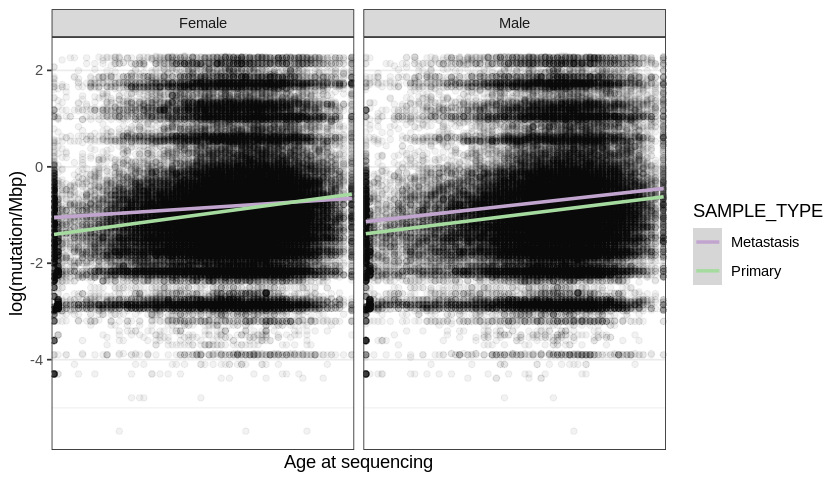

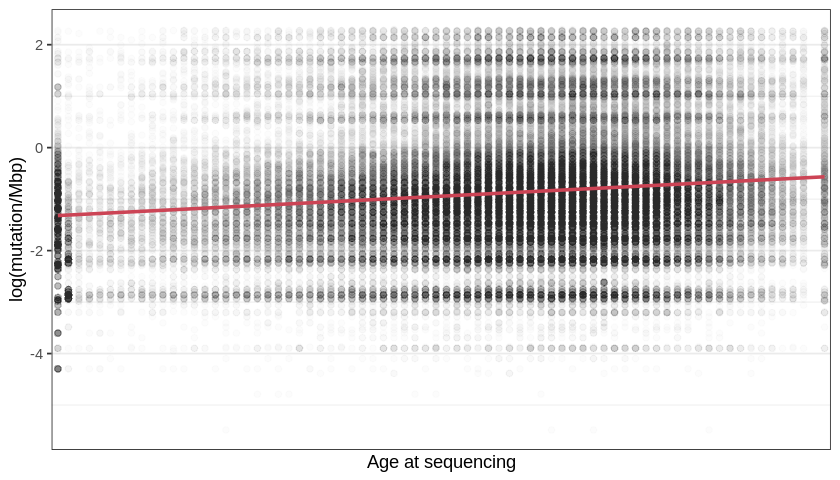

In [23]:
ggplot(reg_table, aes(x=AGE_AT_SEQ_REPORT, y=log(mutation_per_Mbp))) +
  geom_point(alpha=0.05) +
  scale_x_discrete(guide = guide_axis(angle = -90)) +
  geom_smooth(method='lm', formula=y ~ x, aes(color=SAMPLE_TYPE)) +
  facet_wrap(~SEX) +
  scale_colour_manual(values = c("#c2a5cf", "#a6dba0")) +
  theme_bw()  +
  xlab('Age at sequencing') +
  ylab('log(mutation/Mbp)')

ggplot(reg_table, aes(x=AGE_AT_SEQ_REPORT, y=log(mutation_per_Mbp))) +
  geom_point(alpha=0.01) +
  scale_x_discrete(guide = guide_axis(angle = -90)) +
  geom_smooth(method='lm', formula=y ~ x, colour = '#cc4455') +
  theme_bw() +
  xlab('Age at sequencing') +
  ylab('log(mutation/Mbp)')

`summarise()` has grouped output by 'SEX', 'SAMPLE_TYPE'. You can override using the `.groups` argument.


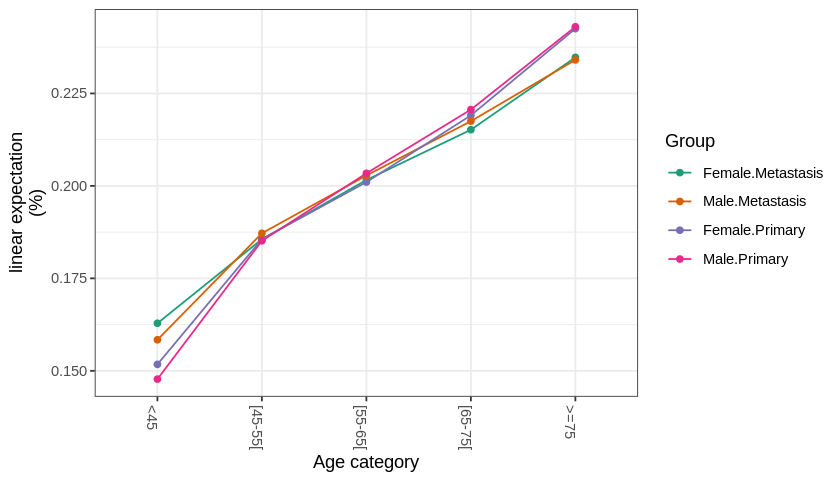

In [24]:
linear_expectation <- reg_table %>% mutate(log_exp = predict(full_model, reg_table))
linear_expectation <- linear_expectation %>% mutate(exp = exp(log_exp))
linear_expectation <- linear_expectation %>% group_by(SEX, SAMPLE_TYPE, age_interval) %>% summarize(mean_exp = mean(exp))
linear_expectation <- linear_expectation %>% group_by(SEX, SAMPLE_TYPE) %>% mutate(freq = mean_exp/sum(mean_exp))


ggplot(linear_expectation, aes(x = age_interval, y = freq, group=interaction(SEX, SAMPLE_TYPE), colour=interaction(SEX, SAMPLE_TYPE))) +
  geom_line() +
  geom_point() +
  theme_bw() +
    theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
  scale_color_brewer(palette = "Dark2") +
  xlab('Age category') +
  ylab('linear expectation\n(%)')  +
  labs(colour='Group')

In [25]:
write.csv(linear_expectation, "../../derived_data/linear_expectation_full.csv", row.names=TRUE)

## Linear regression by cancer type

To further develop our expectations, we want to do the linear regression again, but dividing the data into the diferent cancer types.

In [26]:
# removing a single datapoint which is no correct
reg_table <- reg_table[!(reg_table$CANCER_TYPE == 'Prostate Cancer' & reg_table$SEX == 'Female'),]

In [27]:
# Dince I want to do cancer-specific regression, I have to divide my data based on cancer-type
# In the sample data there are three different columns that tell somthing about the cancer-type
# I examined the length of each in the original sample-data and used the shortest one
# This is because I still want a decent amount of data for each regression,
# and using a wrough-grain method will make that easier

length(unique(sample_data$ONCOTREE_CODE))
length(unique(sample_data$CANCER_TYPE))
length(unique(sample_data$CANCER_TYPE_DETAILED))

[1] 821

[1] 111

[1] 804

In [28]:
# Creating a table of how many patients have the different cancer-types
n_cancer <- as.data.frame(table(reg_table$CANCER_TYPE))

# How many cancer-types before filtering?
nrow(n_cancer)
#head(n_cancer)

# we are only interested in cancers with at least 1500 individuals

# We filter by the number of patients with each cancer
n_cancer <- n_cancer %>% filter(Freq >= 1500)

# How many caner-types adter filtering?
nrow(n_cancer)

# How does the final cancer-type table look?
n_cancer

[1] 105

[1] 18

Var1,Freq
<fct>,<int>
Bladder Cancer,3615
Breast Cancer,12352
Cancer of Unknown Primary,3096
Colorectal Cancer,13272
Endometrial Cancer,4884
Esophagogastric Cancer,4009
Glioma,8446
Head and Neck Cancer,1700
Hepatobiliary Cancer,2875


In [29]:
list(unique(n_cancer$Var1))

[[1]]
 [1] Bladder Cancer             Breast Cancer             
 [3] Cancer of Unknown Primary  Colorectal Cancer         
 [5] Endometrial Cancer         Esophagogastric Cancer    
 [7] Glioma                     Head and Neck Cancer      
 [9] Hepatobiliary Cancer       Mature B-Cell Neoplasms   
[11] Melanoma                   Non-Small Cell Lung Cancer
[13] Ovarian Cancer             Pancreatic Cancer         
[15] Prostate Cancer            Renal Cell Carcinoma      
[17] Soft Tissue Sarcoma        Thyroid Cancer            
105 Levels: Adenocarcinoma In Situ ... Wilms Tumor

In [30]:
cancer_of_interest <- c('Bladder Cancer',
                        'Breast Cancer',
                        'Colorectal Cancer',
                        'Endometrial Cancer',
                        'Esophagogastric Cancer',
                        'Glioma',
                        'Head and Neck Cancer',
                        'Hepatobiliary Cancer',
                        'Mature B-Cell Neoplasms',
                        'Melanoma',
                        'Non-Small Cell Lung Cancer',
                        'Ovarian Cancer',
                        'Pancreatic Cancer',
                        'Prostate Cancer',
                        'Renal Cell Carcinoma',
                        'Soft Tissue Sarcoma',
                        'Thyroid Cancer')

In [31]:
# We create an empty dataframe for our regression results
reg_results <- data.frame(matrix(ncol = 8, nrow = 0))
# We assign names to our columns
colnames(reg_results) <- c('p', 'Estimate', 'Std. Error', 't value', 'Pr(>|t|)', 'Cancer')

# We make a table for our expectation results
exp_results <- data.frame(matrix(ncol = 8, nrow = 0))
# And name the columns herein
colnames(exp_results) <- c('mutation_per_Mbp', 'AGE_AT_SEQ_REPORT', 'SAMPLE_TYPE', 'CANCER_TYPE', 'SEX', 'length_in_bp', 'age_interval', 'exp')

# We make a slightly smaller reg_table for our regression
reg_table <- reg_table %>% select(mutation_per_Mbp, AGE_AT_SEQ_REPORT, SAMPLE_TYPE, CANCER_TYPE, SEX, length_in_bp, age_interval)

# We loop through each cancer type with enough data
for (cancer_type in cancer_of_interest){
    # We create a table containing only that cancer type
    cancer_reg_table <- reg_table[which(reg_table$CANCER_TYPE == cancer_type),]
    
    # If there is only one sex we do not include it in our regression
    if (length(unique(cancer_reg_table$SEX)) != 2 & length(unique(cancer_reg_table$SAMPLE_TYPE)) == 2 ){
        # Defining the linear regression formula
        all <- lm(log(mutation_per_Mbp) ~ AGE_AT_SEQ_REPORT + SAMPLE_TYPE + length_in_bp, data=cancer_reg_table)
    }
    # If there is only one sample-type we do not include it in our regression
    else if (length(unique(cancer_reg_table$SEX)) == 2 & length(unique(cancer_reg_table$SAMPLE_TYPE)) != 2 ){
        all <- lm(log(mutation_per_Mbp) ~ AGE_AT_SEQ_REPORT + SEX + length_in_bp, data=cancer_reg_table)
    }
    # If both sample-type and sex only have one level we do not include it in the regression
    else if (length(unique(cancer_reg_table$SEX)) != 2 & length(unique(cancer_reg_table$SAMPLE_TYPE)) != 2 ){
        all <- lm(log(mutation_per_Mbp) ~ AGE_AT_SEQ_REPORT + length_in_bp, data=cancer_reg_table)
    }
    # If nothing else catches, we include both sex and sample-type in our regression
    else{
        all <- lm(log(mutation_per_Mbp) ~ AGE_AT_SEQ_REPORT + SAMPLE_TYPE + SEX + length_in_bp, data=cancer_reg_table)
    }
    
    # We make a dataframe containing the summary statistics coefficients
    a <- as.data.frame(summary(all)$coefficients)
    # We add a cancer column
    a <- a %>% mutate(Cancer = cancer_type)
    # And add the dataframe to our result dataframe
    reg_results <- rbind(reg_results, a)
    
    # Then we create a copy of the cancer-reg-table
    cancer_reg_table_cpy <- cancer_reg_table
    # And add the *predicted* mutation burden
    # ** not really a prediction because we are using the same data, but that is the function we use
    cancer_reg_table_cpy <- cancer_reg_table_cpy %>% mutate(log_exp = predict(all, cancer_reg_table))
    # Changing it to not be log-transformed
    cancer_reg_table_cpy <- cancer_reg_table_cpy %>% mutate(exp = exp(log_exp))
    # Then we add the exp results to our dataframe
    exp_results <- rbind(exp_results, cancer_reg_table_cpy)
}

# Cheking the regression results
head(reg_results)
# Checking the expectation results
head(exp_results)

,Estimate,Std. Error,t value,Pr(>|t|),Cancer
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-8.754708e-01,9.643439e-02,-9.078409,1.770881e-19,Bladder Cancer
AGE_AT_SEQ_REPORT,9.521561e-03,1.302082e-03,7.312569,3.211924e-13,Bladder Cancer
SAMPLE_TYPEPrimary,-4.977370e-02,3.457535e-02,-1.439572,1.500753e-01,Bladder Cancer
SEXMale,5.517379e-02,3.199447e-02,1.724479,8.470699e-02,Bladder Cancer
length_in_bp,-1.321260e-08,6.693555e-10,-19.739281,1.908339e-82,Bladder Cancer
(Intercept)1,-9.084607e-01,4.014916e-02,-22.627140,4.186703e-111,Breast Cancer


,mutation_per_Mbp,AGE_AT_SEQ_REPORT,SAMPLE_TYPE,CANCER_TYPE,SEX,length_in_bp,age_interval,log_exp,exp
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<fct>,<dbl>,<dbl>
658,1.4017484,77,Primary,Bladder Cancer,Female,16408080,>=75,-0.4088776,0.6643955
671,0.6704014,67,Metastasis,Bladder Cancer,Female,16408080,[65-75[,-0.4543195,0.6348798
677,1.2189117,80,Primary,Bladder Cancer,Female,16408080,>=75,-0.3803130,0.6836474
683,0.9141837,87,Metastasis,Bladder Cancer,Female,16408080,>=75,-0.2638883,0.7680593
705,1.5845852,90,Primary,Bladder Cancer,Male,16408080,>=75,-0.2299236,0.7945943
708,1.0970205,56,Metastasis,Bladder Cancer,Male,16408080,[55-65[,-0.5038829,0.6041801


`summarise()` has grouped output by 'CANCER_TYPE', 'SEX', 'SAMPLE_TYPE'. You can override using the `.groups`
argument.


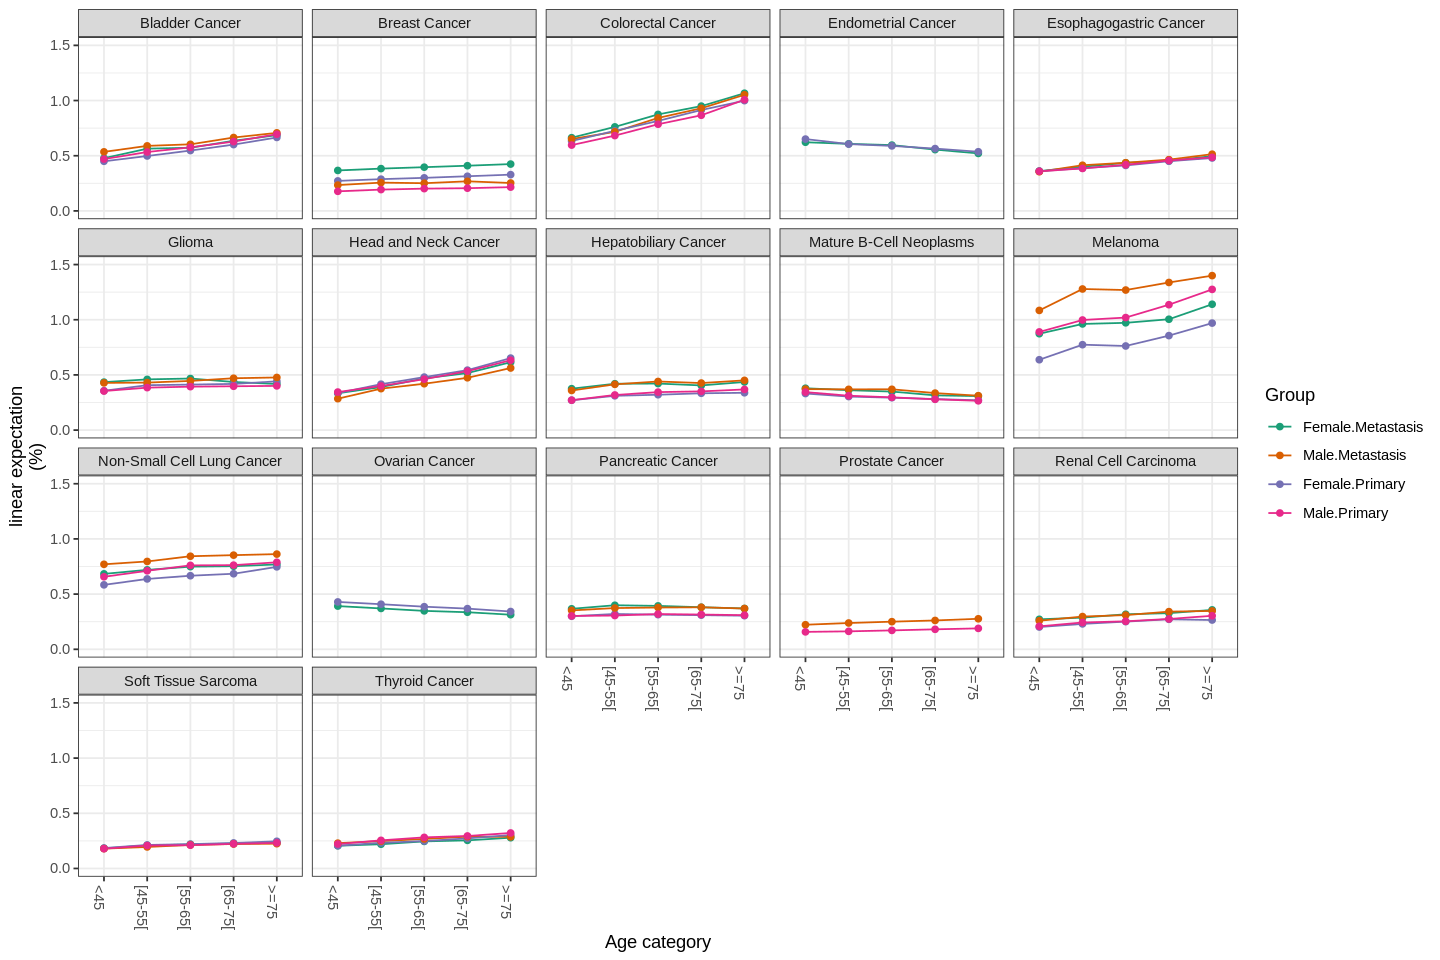

In [35]:
options(repr.plot.width=12, repr.plot.height=8)

exp_results_mean <- exp_results %>% group_by(CANCER_TYPE, SEX, SAMPLE_TYPE, age_interval) %>% summarize(mean_exp = mean(exp))

ggplot(exp_results_mean, aes(x = age_interval, y = mean_exp, group=interaction(SEX, SAMPLE_TYPE), colour=interaction(SEX, SAMPLE_TYPE))) +
  geom_line() +
  geom_point() +
  theme_bw() +
  scale_color_brewer(palette = "Dark2") +
  facet_wrap(~CANCER_TYPE) +
  theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
  ylim(0, 1.5) +
  xlab('Age category') +
  ylab('linear expectation\n(%)') +
  labs(colour='Group')

In [33]:
write.csv(exp_results_mean, '../../derived_data/linear_expectation_by_cancer_mean.csv', row.names=TRUE)